
## Гибридные рекомендательные системы с Surprise: взвешенный подход

Дедлайн 1: 18 октября. Дедлайн 2 (максимальная оценка - 1 балл) 25 октября

### Мы используем Suprise (пакет sci-kit для рекомендательных систем), чтобы гарантировать, что рекомендательные системы, которые мы используем, оптимизированы, чтобы когда мы объединили их - не беспокоились о недостатках, возникающих в отдельной реализации. 

In [1]:
import surprise
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
path = "/"
#print(os.listdir(path))

Во-первых, давайте прочитаем и очистим набор данных, чтобы мы знали, с чем работаем.
1. Считайте pandas датафрейм ratings.csv
2. Удалите дублированные строки
3. Сколько уникальных книг и пользователей в датасете?
4. В каком интервале рейтинг?

Всякий раз, когда вы загружаете набор данных в Surprise, вы можете использовать их класс Reader набора данных, который облегчает большую часть проблем. Вы можете указать множество форматов файлов, но для фреймов данных pandas, которые мы используем, вы можете указать некоторые параметры для рейтинга (rating_scale) и датафрейма.

In [3]:
df = pd.read_csv('ratings.csv')
df = df.drop_duplicates()

print("Unique books:", df.book_id.unique().shape[0])
print("Interval:", df.rating.min(), ":", df.rating.max())
df = df.iloc[:-500000]

df.rating = df.rating.astype('int8')
# print(df.head(), df.shape)

#порядок колонок должен быть таким
df=df[['user_id','book_id','rating']] 
df.columns = ['n_users','n_items','rating']

# укажем scale для рейтинга
reader = surprise.Reader(rating_scale=(1,5)) 

# разделите на основную и отложенную выборки в соотножении 3:1
# и загрузите в surprise dataset:
#  -- TODO -- 

#holdout = surprise.Dataset.load_from_df(df.iloc[-500000:], reader)
train, test = train_test_split(df, test_size=0.3)
train = surprise.Dataset.load_from_df(train, reader)
test = surprise.Dataset.load_from_df(test, reader)

Unique books: 10000
Interval: 1 : 5



### Во-первых, выберем несколько алгоритмов для включения в наш ансамбль. Это будут
1. KNN совместная фильтрация 
2. Матричная факторизация
3. Совместная фильтрация с кластеризацией
4. Совместная фильтрация на основе алгоритма Slope One. (http://wiki-org.ru/wiki/Slope_One)

## KNN колаборативная фильтрация:

In [4]:
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True) # разбиваем данные на фолды


Задайте параметр sim_options на основании косинусной меры, и с подходом user-based ('user_based': False)

In [5]:
sim_options = {
    'name': 'cosine',
    'user_based': False
    }
collabKNN = surprise.KNNBasic(k=10, **sim_options)

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [6]:
rmseKNN = []
for trainset, testset in kSplit.split(train): #проходимся по фолдам
    model = collabKNN.fit(trainset)
    preds = model.test(testset)
    rmseKNN.append(surprise.accuracy.rmse(preds))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9294
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9313
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9318
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9293
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9263
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9304
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9324
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9398
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9252
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9279


### Вы можете пробовать разные гиперпараметры, используя Suprise Grid Search CV, чтобы найти наилучшие возможные гиперпараметры.


### Обучим наш алгоритм матричной факторизации с 30 скрытыми факторами (n_factors=30)


In [7]:
funkSVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [9]:
rmseSVD = []
for trainset, testset in kSplit.split(train): #проходимся по фолдам
    preds = funkSVD.fit(trainset).test(testset)
    rmseSVD.append(surprise.accuracy.rmse(preds))

RMSE: 0.8664
RMSE: 0.8667
RMSE: 0.8612
RMSE: 0.8669
RMSE: 0.8632
RMSE: 0.8663
RMSE: 0.8667
RMSE: 0.8672
RMSE: 0.8665
RMSE: 0.8633


## Колаборативная фильтрация с кластеризацией


Теперь используем совместную фильтрацию с кластеризацией.
Совместная кластеризация - это объединение пользователей и элементов в кластеры с использованием методов кластеризации. Выделите три кластера. Чтобы получить прогнозируемый рейтинг, вам нужно будет суммировать три вещи:
     1. Вы находите кластер для указанного рейтинга пользователя u и элемента i и определяете среднее значение этого кластера. Итак, вы найдете среднее значение кластера u_i.
     2. Найдите среднее значение кластера элемента i и вычтите его из среднего рейтинга этого элемента.
     3. Найдите среднее значение кластера пользователя u и вычтите его из среднего рейтинга этого пользователя.
    
Вы обнаружите, что для большинства из них RSME остается неизменным для всех K-фолдов.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [10]:
coClus = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25) 
rmseCo = []
for trainset, testset in kSplit.split(train): #проходимся по фолдам
    preds = coClus.fit(trainset).test(testset)
    rmseCo.append(surprise.accuracy.rmse(preds))

RMSE: 0.8946
RMSE: 0.9002
RMSE: 0.8956
RMSE: 0.9023
RMSE: 0.9049
RMSE: 0.9005
RMSE: 0.8950
RMSE: 0.9000
RMSE: 0.9008
RMSE: 0.8927


## Slope One

Обучая нашу последнюю модель, мы будем использовать алгоритм совместной фильтрации Slope One. Этот алгоритм вычисляет наклон (slope) каждого из релевантных элементов, оцененных пользователем, находит разницу, а затем вычисляет прогноз. Это грубый инструмент, но это хорошая эвристика, которая может улучшить наш метод ансамбля. Подробнее читайте здесь: https://arxiv.org/abs/cs/0702144.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [11]:
slopeOne = surprise.prediction_algorithms.slope_one.SlopeOne()


In [12]:
rmseSlope = []
for trainset, testset in kSplit.split(train): 
    preds = slopeOne.fit(trainset).test(testset)
    rmseSlope.append(surprise.accuracy.rmse(preds))

RMSE: 0.9229
RMSE: 0.9136
RMSE: 0.9278
RMSE: 0.9241
RMSE: 0.9223
RMSE: 0.9258
RMSE: 0.9270
RMSE: 0.9156
RMSE: 0.9249
RMSE: 0.9251


Теперь у нас есть четыре рекомендательные системы, из которых мы хотим сделать ансамбль. Сначала давайте построим график каждого из них, чтобы увидеть, как они работают.

Затем реализуем описанный алгоритм Ensemble для гибридного подхода.

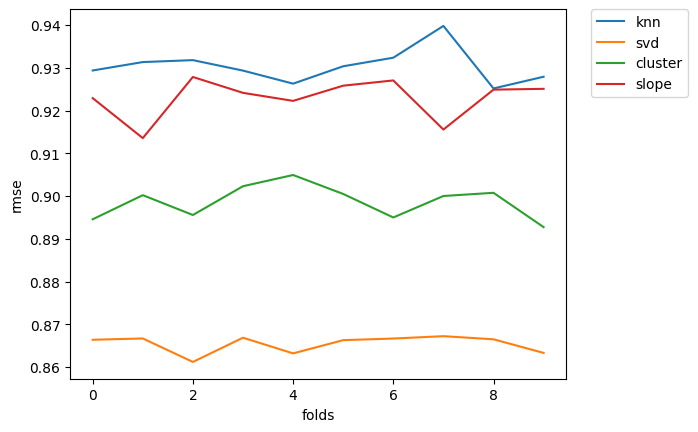

In [13]:
#Отобразим предсказания:
import matplotlib.pyplot as plt
modelPrediction = plt.plot(rmseKNN,label='knn')
modelPrediction = plt.plot(rmseSVD,label='svd')
modelPrediction = plt.plot(rmseCo,label='cluster')
modelPrediction = plt.plot(rmseSlope,label='slope')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Похоже, что svd превосходит остальные. Попробуем гибридизировать модели, чтобы получить лучшие части каждой модели. Для этого мы собираемся использовать Suprise, чтобы создать новый алгоритм, и сделать так, чтобы он превосходил остальные.


# На псевдокоде наш алгоритм выглядит следующим образом:
1. Мы запускаем несколько рекомендательных систем для набора данных.
2. Инициализируем взвешенную переменную alpha равную 1 / q, где q - количество используемых нами рекомендательных систем.
3. Итоговый рейтинг будем считать как сумму взвещаных прогнозируемых рейтингов.
4. Используя градиентный спуск, оптимизируем альфа-член по пространству параметров, чтобы иметь возможность придать наибольший вес модели, которая может представлять лучший прогноз.

Теперь создадим класс в Surprise и унаследуем его от Algobase.

In [14]:
class HybridFacto(surprise.AlgoBase):
    def __init__(self,epochs, learning_rate,q,estimators):
        self.alpha = np.array([1/q]*q)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.collabKNN = estimators[0]
        self.funkSVD = estimators[1]
        self.coClus = estimators[2]
        self.slopeOne = estimators[3]
    
    def fit(self, train_set):
        holdout=train_set.build_full_trainset().build_testset()
        predictions = []
        predictions.append(self.collabKNN.test(holdout))
        predictions.append(self.funkSVD.test(holdout))
        predictions.append(self.coClus.test(holdout))
        predictions.append(self.slopeOne.test(holdout))
        for epoch in range(self.epochs):
            maeGradient = np.array([surprise.accuracy.mae(prediction) for prediction in predictions])
            newalpha =  self.alpha - maeGradient * self.learning_rate
            #проверка сходимости:
            if (newalpha - self.alpha).max() < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,testset):
        algoResults=[np.array([i.est for i in collabKNN.test(testset)]),
                     np.array([i.est for i in funkSVD.test(testset)]),
                     np.array([i.est for i in coClus.test(testset)]),
                     np.array([i.est for i in slopeOne.test(testset)])]
        return self.alpha @ algoResults
        

давайте проверим его:
1. Инициализруйте Гибридную модель с 10 эпохами, learning_rate = 0.05, по 4 имеющимся моделям и обучите на holdout выборке
2. Посчитайте root mean squared error с использованием метрики из sklearn для получившегося результата
3. Отобразите на графике результаты метрики, полученые от одиночных моделей на предыдущих шагах вместе с результатом гибридной модели. Оцените результат

In [48]:
estimators = [collabKNN, funkSVD, coClus, slopeOne]
hybrid = HybridFacto(epochs=10, learning_rate=0.05, q=4, estimators=estimators)
hybrid.fit(test)

MAE:  0.7175
MAE:  0.6808
MAE:  0.6909
MAE:  0.7076


In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmseHyb = []
for trainset, testset in kSplit.split(test):
    preds = hybrid.estimate(testset)
    rmse_hyb = mean_squared_error([i[2] for i in testset], pred)
    rmseHyb.append(rmse_hyb)

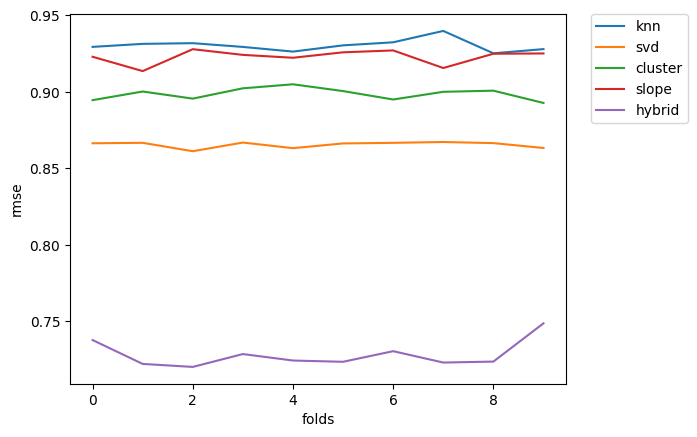

In [50]:
import matplotlib.pyplot as plt
modelPrediction = plt.plot(rmseKNN,label='knn')
modelPrediction = plt.plot(rmseSVD,label='svd')
modelPrediction = plt.plot(rmseCo,label='cluster')
modelPrediction = plt.plot(rmseSlope,label='slope')
modelPrediction = plt.plot(rmseHyb,label='hybrid')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)